# Homework 2: Classification With Support Vector Machines


## Setup and Loading Dat

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
plt.close('all')

In [49]:
def loadData():
    training = pd.read_csv('./data/train.txt', header=None)
    testing = pd.read_csv('./data/test.txt', header=None)
    return training, testing

In [65]:
def getOnlyContinuousColumns(data, includeClass=False):
    continuous_columns = [0,2,4,10,11,12]
    if includeClass:
        continuous_columns.append(14)
    return data[continuous_columns]

In [66]:
training, testing = loadData()
cleanedTrainingData = getOnlyContinuousColumns(training, True)
cleanedTestingData = getOnlyContinuousColumns(testing)
print(f"Loaded {training.shape[0]} training rows and {testing.shape[0]} rows")

Loaded 43957 training rows and 4885 rows


## Explore

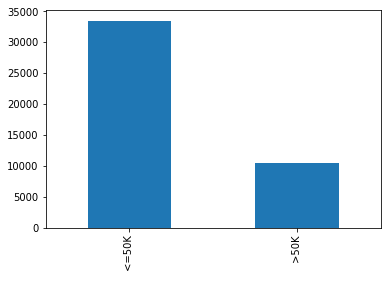

In [120]:
cleanedTrainingData[14].value_counts().plot(kind='bar')
plt.show()

In [131]:
cleanedTrainingData.describe()

,0,2,4,10,11,12
count,43957.000000,4.395700e+04,43957.000000,43957.000000,43957.000000,43957.000000
mean,38.635121,1.897506e+05,10.078531,1088.224538,86.624337,40.413768
std,13.709061,1.059574e+05,2.566403,7548.199742,400.228624,12.326645
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175670e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.779740e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376300e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000
